In [59]:
import torch
from models import MMLorentzKG
from datasets import Dataset, DATA_PATH
import json
import os



In [66]:
def load_ent2id(ent2id_path):
    out = {}
    with open(ent2id_path, 'r') as f:
        for line in f.readlines():
            name, id = line.strip().split('\t')
            out[int(id)] = name
    return out

def load_ent2type(ent2type_path):
    out, types = {}, []
    out_ent2typeid = {}
    with open(ent2type_path, 'r') as f:
        for line in f.readlines():
            name, type = line.strip().split('\t')
            type = type.split('/')[1]
            out[name] = type
            types.append(type)
    
    type2id = {}
    types = list(set(types))
    for i, type in enumerate(types):
        type2id[type] = i
    
    for name, type in out.items():
        out_ent2typeid[name] = type2id[type]

    return out, out_ent2typeid, types

def load_config(conf_path):
    import argparse
    with open(conf_path, 'r') as f:
        conf = json.load(f)

    return argparse.Namespace(**conf)


def get_entid2enttypeid(id2ent, ent2typeid):
    import numpy as np
    out = {}
    for entid, entname in id2ent.items():
        try:
            out[entid] = ent2typeid[entname]
        except:
            out[entid] = 89
    
    out = sorted(out.items(), key=lambda x:x[0])
    out = np.array(out)
    return out[:, -1]
    

In [70]:

ent2id_path = '/home/user/KnowledgeGraph/MoSE_MCL/data/FB15K/ent_id'
ent2type = '/home/user/KnowledgeGraph/MoSE_MCL/data/FB15K/FB15k_Entity_Type.txt'
model_path = '/data/liuruizhou/MMKGE_model/MoSE_MCL/logs/08_08/FB15K-237/MMLorentzKG_16_41_48/model.pt'
config_path = '/data/liuruizhou/MMKGE_model/MoSE_MCL/logs/08_08/FB15K-237/MMLorentzKG_16_41_48/config.json'
device = torch.device('cpu')


id2ent = load_ent2id(ent2id_path)
ent2type, ent2typeid, types = load_ent2type(ent2type)
ent_typs = get_entid2enttypeid(id2ent, ent2typeid)
args = load_config(config_path)
img_info  = os.path.join(DATA_PATH, args.dataset, "vis_embeddings.pkl") if args.fusion_img  else None
dscp_info = os.path.join(DATA_PATH, args.dataset, "txt_embeddings.pkl") if args.fusion_dscp else None

dataset = Dataset('FB15K-237', device=device)
model = MMLorentzKG(dataset.get_shape(), rank=args.rank, args=args, visu_path=img_info, ling_path=dscp_info, device=device)
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [71]:
with torch.no_grad():
    visu_entities, _ = model.visu_fusion(model.stru_entities.clone().detach(), model.visu_embeds)
    ling_entities, _ = model.ling_fusion(model.stru_entities.clone().detach(), model.ling_embeds)
    stru_entities = model.stru_entities.clone().detach()

    visu_entities = visu_entities.view(dataset.get_shape()[0], -1)
    ling_entities = ling_entities.view(dataset.get_shape()[0], -1)
    stru_entities = stru_entities.view(dataset.get_shape()[0], -1)

    entities = torch.cat([stru_entities, visu_entities, ling_entities], dim=-1)

    print(f"visu_entities.shape: {visu_entities.shape}")
    print(f"ling_entities.shape: {ling_entities.shape}")
    print(f"stru_entities.shape: {stru_entities.shape}")
    print(f"entities.shape: {entities.shape}")



visu_entities.shape: torch.Size([14541, 7000])
ling_entities.shape: torch.Size([14541, 7000])
stru_entities.shape: torch.Size([14541, 7000])
entities.shape: torch.Size([14541, 21000])


tensor(13071)


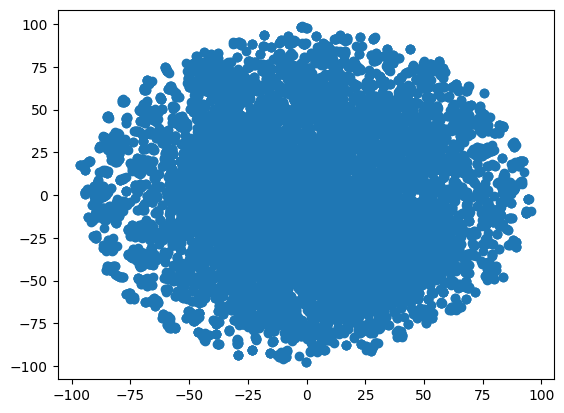

In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne_data = TSNE(learning_rate='auto', init='random', perplexity=3).fit_transform(entities)

In [84]:
import umap
visualizer = umap.UMAP()
umap_data = visualizer.fit_transform(entities)

2023-08-08 17:30:21.115725: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 17:30:21.209034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 17:30:22.134859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensor(578)


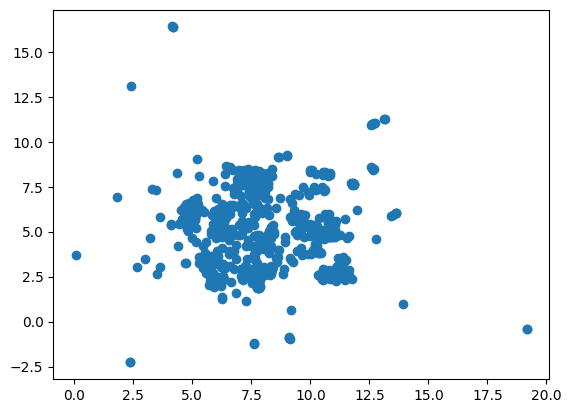

In [88]:
visu_data = umap_data
cands = torch.rand(size=(visu_data.shape[0],)) < 0.04
print(cands.sum())

for type_i in ent
plt.scatter(visu_data[cands, 0], visu_data[cands, 1])

tensor(1457)


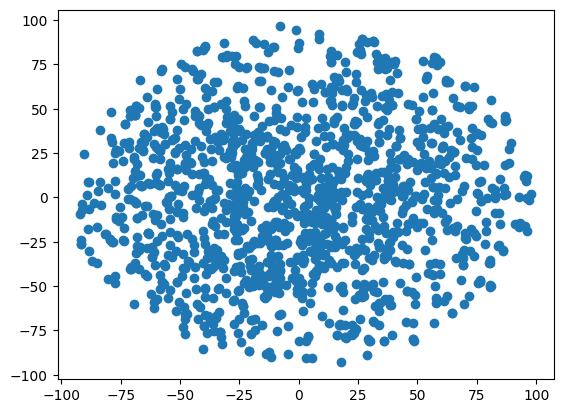